Import

In [1]:
!git clone https://github.com/AndreasHammerKU/CardiacCTAnalysis.git
%cd CardiacCTAnalysis

Cloning into 'CardiacCTAnalysis'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 61 (delta 17), reused 45 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (61/61), 557.95 KiB | 2.09 MiB/s, done.
Resolving deltas: 100% (17/17), done.
/content/CardiacCTAnalysis


In [2]:
from google.colab import drive
drive.mount('/content/drive')

dataset_folder = '/content/drive/MyDrive/Data'

import nibabel as nib
import json
import os

def load_nifti(file_path):
    nii_img = nib.load(file_path)
    affine = nii_img.affine  # Get transformation matrix
    return nii_img.get_fdata(), affine

def load_data(image_name):
    # Load NIfTI file
    nifti_path = os.path.join(dataset_folder, 'images', image_name + '.nii.gz')
    nifti_data, affine = load_nifti(nifti_path)

    # Check scanner orientation

    # Load landmark JSON
    with open(os.path.join(dataset_folder, 'landmarks', image_name + '.json')) as file:
        landmark_data = json.load(file)

    return nifti_data, affine, landmark_data

Mounted at /content/drive


In [3]:
!pip install dash
import utils.geometry_fitting as geom
import utils.visualiser as vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 26.2 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.0
    Uninstalling Flask-3.1.0:
      Successfully uninstalled Flask-3.1.0


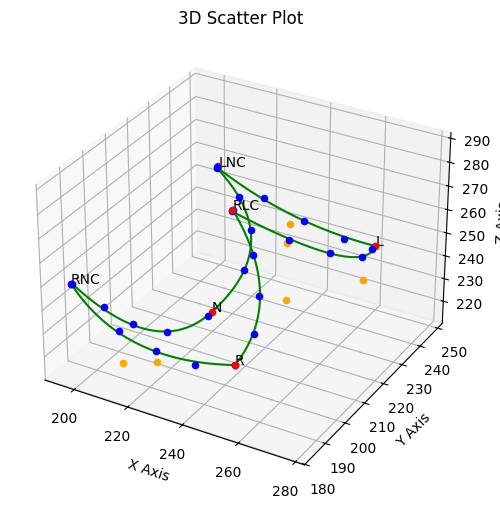

In [4]:
image, affine, landmarks = load_data('n1')
landmarks = vis.ras_to_lps(landmarks)
voxel_landmarks = vis.world_to_voxel(landmarks=landmarks, affine=affine)
geometry = geom.LeafletGeometry(voxel_landmarks)
geometry.calculate_bezier_curves()
geometry.plot(plot_label_points=True, plot_control_points=True)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from scipy.special import binom
from collections import deque

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [76]:
# Function to compute Bézier curve points given control points
def bezier_curve(p0, p1, p2, t):
    curve = np.outer((1 - t) ** 2, p0) + np.outer(2 * (1 - t) * t, p1) + np.outer(t ** 2, p2)
    return curve.astype(int)  # Convert to integer indices for accessing grid values

# Define a 3D environment for the agent
class Bezier3DEnv:
    def __init__(self, grid, p0, p2, ground_truth, lambda_reg=0.001, num_points=5):
        self.grid = grid  # 3D numpy array (image)
        self.p0 = np.array(p0)  # Start point of Bézier curve
        self.p2 = np.array(p2)  # End point of Bézier curve
        self.ground_truth = np.array(ground_truth)  # True control point
        self.state = (self.p0 + self.p2) // 2  # Start in the midpoint
        self.actions = [(-1, 0, 0), (1, 0, 0), (0, -1, 0), (0, 1, 0), (0, 0, -1), (0, 0, 1)]  # Move in 6 directions
        self.lambda_reg = lambda_reg # Regularization
        self.t_points = np.linspace(0, 1, num_points)
        self.gradient = np.gradient(self.grid)  # Compute gradients in 3D space

    def reset(self):
        self.state = (self.p0 + self.p2) // 2  # Reset to midpoint
        return self.state

    def step(self, action):
        new_state = np.clip(self.state + np.array(self.actions[action]), [0, 0, 0], np.array(self.grid.shape) - 1)
        curve_points = bezier_curve(self.p0, new_state, self.p2, self.t_points)  # Compute Bézier curve


        # Compute reward: sum of gradient magnitudes along the curve
        reward = np.sum([np.linalg.norm([g[tuple(pt)] for g in self.gradient]) for pt in curve_points]) - (self.lambda_reg * np.linalg.norm(new_state - (self.p0 + self.p2) // 2))**2

        self.state = new_state
        done = np.array_equal(self.state, self.ground_truth)  # Stop if agent reaches the ground truth control point
        return self.state, reward, done

# Define a simple Q-network
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DQN Agent
class DQNAgent:
    def __init__(self, state_dim, action_dim, model, lr=0.001, gamma=0.99, epsilon=1.0, min_epsilon=0.01, decay=0.995):
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.decay = decay

        self.model = model.to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.MSELoss()
        self.memory = deque(maxlen=1000)

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_dim - 1)
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            return torch.argmax(self.model(state)).item()

    def store_experience(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def train(self, batch_size=32):
        if len(self.memory) < batch_size:
            return

        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device)

        q_values = self.model(states).gather(1, actions).squeeze(1)
        next_q_values = self.model(next_states).max(1)[0].detach()
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        loss = self.criterion(q_values, expected_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.epsilon = max(self.min_epsilon, self.epsilon * self.decay)

# Training loop
def train_dqn(env, model, episodes=500):

    agent = DQNAgent(state_dim=3, action_dim=6, model=model)

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.select_action(state)

            next_state, reward, done = env.step(action)

            print(state, action, reward)
            agent.store_experience(state, action, reward, next_state, done)
            agent.train()
            state = next_state
            total_reward += reward

        print(f"Episode {episode + 1}: Total Reward = {total_reward}")

In [77]:
# Hyperparameters
gamma = 0.9  # Discount factor
lr = 0.01  # Learning rate
epsilon = 0.1  # Exploration rate
episodes = 500
batch_size = 16
memory = deque(maxlen=1000)

Get ground thruth

In [78]:
points = geometry.RCI_left

In [79]:
# Setup environment and model
p0, ground_truth, p2 = points[0], points[1], points[2]  # Control points of bezier curve
ground_truth = np.rint(ground_truth)
env = Bezier3DEnv(image, p0, p2, ground_truth)

state_size = 3
action_size = len(env.actions)
model = QNetwork(state_size, action_size)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

In [80]:
print(ground_truth)

[266. 195. 260.]


In [81]:
train_dqn(env, model)

Streaming output truncated to the last 5000 lines.
[496. 508. 350.] 2 633.5824954056127
[496. 507. 350.] 2 567.4870949796928
[496. 506. 350.] 5 610.0667518876816
[496. 506. 351.] 5 643.7954169607797
[496. 506. 352.] 3 730.8272912923481
[496. 507. 352.] 0 719.8884158660384
[495. 507. 352.] 0 743.0228733125457
[494. 507. 352.] 0 743.0233623125457
[493. 507. 352.] 3 698.9009233894736
[493. 508. 352.] 3 720.2624695053091
[493. 509. 352.] 2 698.9009233894736
[493. 508. 352.] 2 743.0233623125457
[493. 507. 352.] 1 743.0228733125457
[494. 507. 352.] 1 719.8884158660384
[495. 507. 352.] 1 730.8272912923481
[496. 507. 352.] 1 739.9152835858362
[497. 507. 352.] 0 730.8272912923481
[496. 507. 352.] 0 719.8884158660384
[495. 507. 352.] 0 743.0228733125457
[494. 507. 352.] 0 743.0233623125457
[493. 507. 352.] 0 731.5782594765715
[492. 507. 352.] 5 737.1891243309234
[492. 507. 353.] 5 737.1891243309234
[492. 507. 353.] 5 737.1891243309234
[492. 507. 353.] 1 764.8168518678555
[493. 507. 353.] 1 764.8

KeyboardInterrupt: 